# Check outputs of MODIS_HRRR processing 
*J. Michelle Hu  
University of Utah  
August 2024*  
---

In [1]:
import os
import sys
import xarray as xr
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

In [4]:
# Plot the original?
dt = 20190718
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo.tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
stc


<xarray.Dataset> Size: 138MB
Dimensions:      (x: 7200, y: 4800)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 58kB -1.112e+07 -1.112e+07 ... -7.784e+06
  * y            (y) float64 38kB 5.56e+06 5.559e+06 ... 3.337e+06 3.336e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 138MB ...

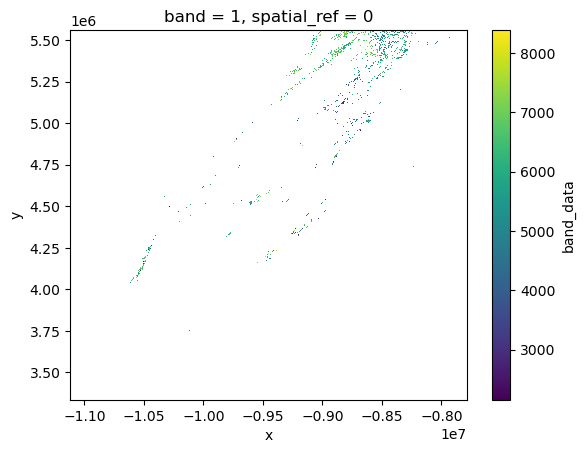

In [5]:
stc.band_data.plot.imshow()

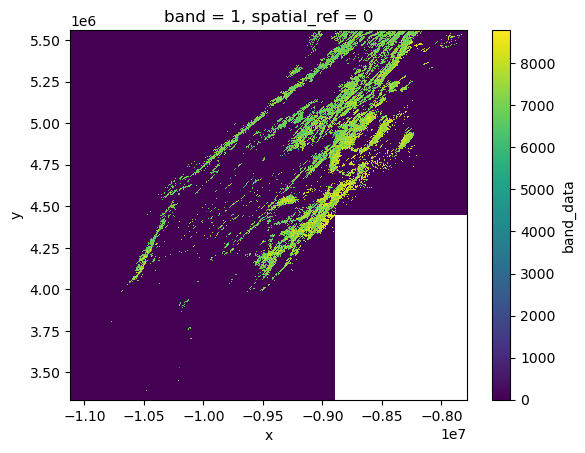

In [6]:
# Plot the original?
dt = '20210421'
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_albedo/wy2021/'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo*tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
stc.band_data.plot.imshow()


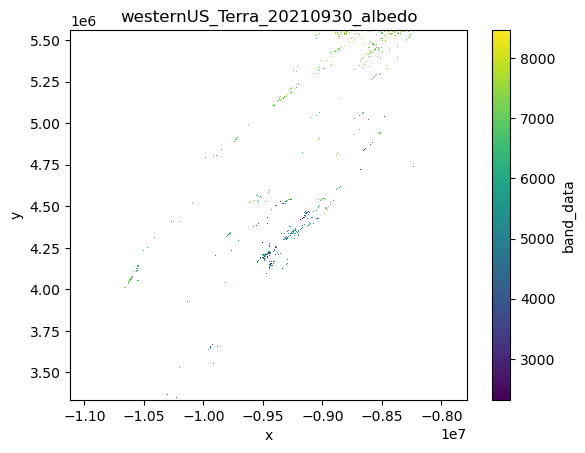

In [7]:
from pathlib import PurePath
# Plot the original?
dt = '20210930'
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo.tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
stc.band_data.plot.imshow()
plt.title(PurePath(stc_fn).stem);

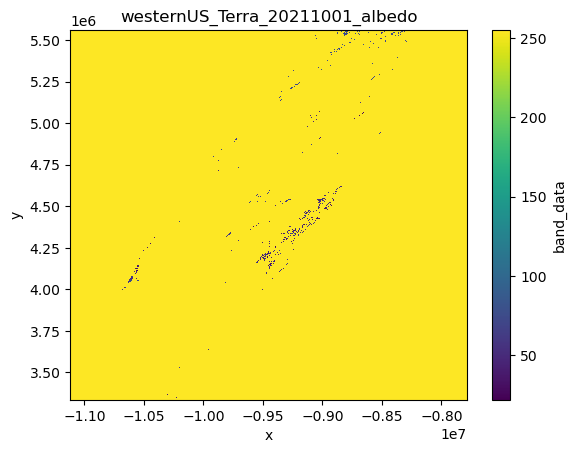

In [8]:
# Plot the original?
dt = '20211001'
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo.tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
stc.band_data.plot.imshow()
plt.title(PurePath(stc_fn).stem);

- WY 2022 onward switches to 0–255 range while maintaining a encoded 65535 no data value when 255 is clearly NDV
- previous to that, valid range appears to be from 0-10000, with encoded nodata value of 65535

### Test from the matlab version

In [9]:
import h5py

from osgeo import gdal, gdalconst, gdal_array
GDAL_GTIFF = 'GTiff'
GDAL_VRT = 'VRT'
GTIFF_DRIVER = gdal.GetDriverByName(GDAL_GTIFF)
GTIFF_DRIVER_OPTS = [
    "COMPRESS=LZW",
    "TILED=YES",
    "BIGTIFF=IF_SAFER",
    "NUM_THREADS=ALL_CPUS"
]


BAND_DATA_TYPE = gdalconst.GDT_UInt16
BAND_NO_DATA_VALUE = 65535
BAND_NUMBER = 1

PROJ = '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs'

def matlab_to_geotiff(matlab_file, output_file, template_file, variable):
    #Create an empty geotiff to put the data in
    template_file = gdal.Open(template_file)
    geotiff = GTIFF_DRIVER.Create(
        output_file,
        template_file.RasterXSize, template_file.RasterYSize,
        BAND_NUMBER, BAND_DATA_TYPE,
        options = GTIFF_DRIVER_OPTS)
    geotiff.SetGeoTransform(template_file.GetGeoTransform())
    geotiff.SetProjection(PROJ)
    
    modis_band = geotiff.GetRasterBand(BAND_NUMBER)
    modis_band.SetNoDataValue(BAND_NO_DATA_VALUE)
    
    data_file = h5py.File(matlab_file)
    gdal_array.BandWriteArray(modis_band, np.array(data_file[variable]).T)
    modis_band.ComputeStatistics(0)
    modis_band.FlushCache()
    
    del data_file
    del modis_band
    del geotiff
    del template_file
    return output_file

In [10]:
from pathlib import PurePath

In [11]:
dt = '20220120'

In [12]:
dt

'20220120'

/uufs/chpc.utah.edu/common/home/u6058223/public_html/20220120_albedo_v03.tif


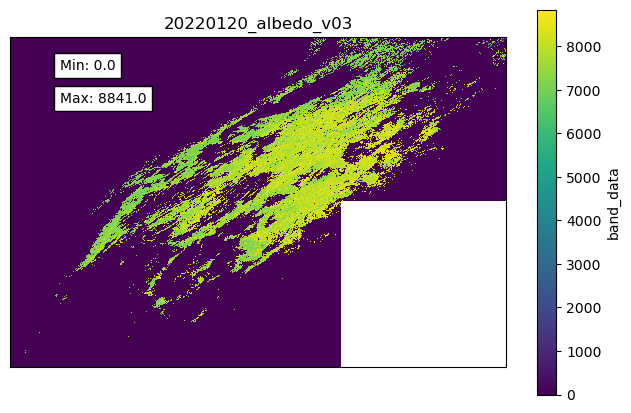

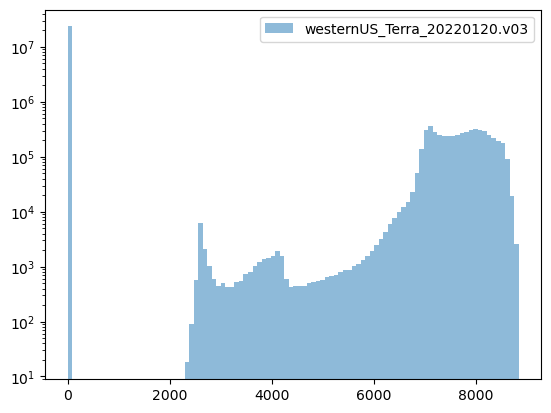

In [13]:
# only up to WY 2022
stc_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_gap-filled/CUB-originals_v03/'
stc_fn = h.fn_list(stc_dir, f'*/*{dt}*mat')[0]
output_file = f"/uufs/chpc.utah.edu/common/home/u6058223/public_html/{dt}_albedo_{stc_dir.split('/')[-2].split('_')[-1]}.tif"
template_file = '/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/snow-rs/src/snow_rs/data/modis/WesternUS.tif'
variable = 'albedo_observed_muZ'
print(output_file)
if not os.path.exists(output_file):
    matlab_to_geotiff(stc_fn, output_file, template_file, variable)

stc_v03 = np.squeeze(xr.open_dataset(output_file))
fig, ax = plt.subplots(1, figsize=(8,5))

arr = stc_v03.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_gap-filled/CUB-originals_v06/2022/westernUS_Terra_20220120.v2023.0.mat
/uufs/chpc.utah.edu/common/home/u6058223/public_html/20220120_albedo_v06.tif


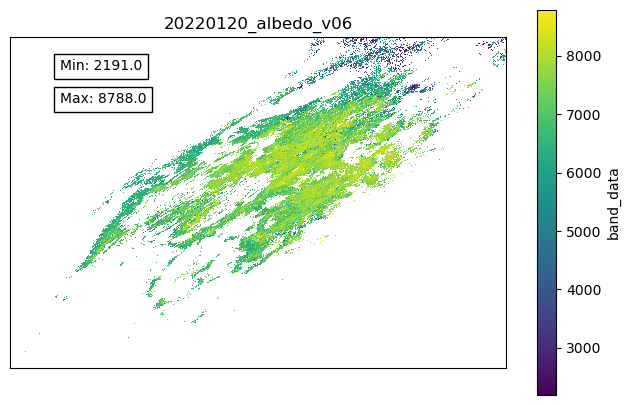

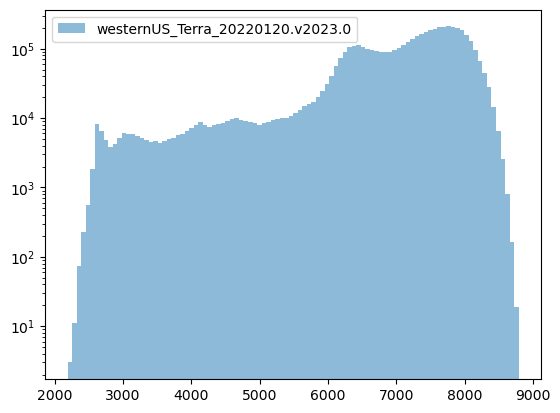

In [14]:
# Up to 2023
stc_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_gap-filled/CUB-originals_v06/'
stc_fn = h.fn_list(stc_dir, f'*/*{dt}*mat')[0]
print(stc_fn)
output_file = f"/uufs/chpc.utah.edu/common/home/u6058223/public_html/{dt}_albedo_{stc_dir.split('/')[-2].split('_')[-1]}.tif"
template_file = '/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/snow-rs/src/snow_rs/data/modis/WesternUS.tif'
variable = 'albedo_observed_muZ'
print(output_file)
if not os.path.exists(output_file):
    matlab_to_geotiff(stc_fn, output_file, template_file, variable)

stc = np.squeeze(xr.open_dataset(output_file))
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

/uufs/chpc.utah.edu/common/home/u6058223/public_html/20220120_albedo_v2023.0e.tif


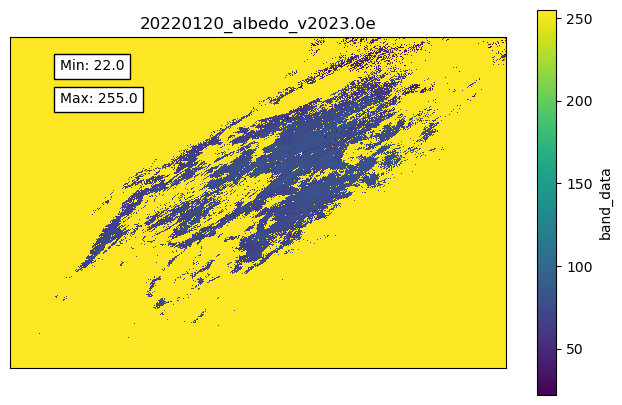

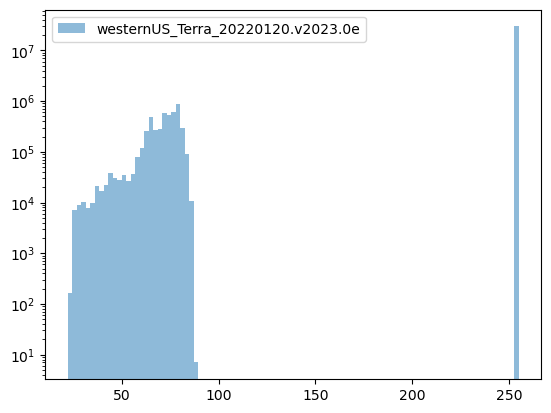

In [15]:
# 2021 through 2023
stc_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_gap-filled/CUB-originals_v2023.0e/'
stc_fn = h.fn_list(stc_dir, f'*/*{dt}*mat')[0]
output_file = f"/uufs/chpc.utah.edu/common/home/u6058223/public_html/{dt}_albedo_{stc_dir.split('/')[-2].split('_')[-1]}.tif"
template_file = '/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/snow-rs/src/snow_rs/data/modis/WesternUS.tif'
variable = 'albedo_observed_muZ'
print(output_file)
if not os.path.exists(output_file):
    matlab_to_geotiff(stc_fn, output_file, template_file, variable)

stc = np.squeeze(xr.open_dataset(output_file))
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

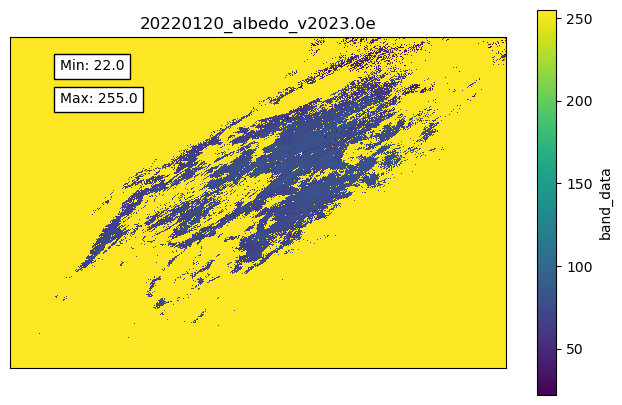

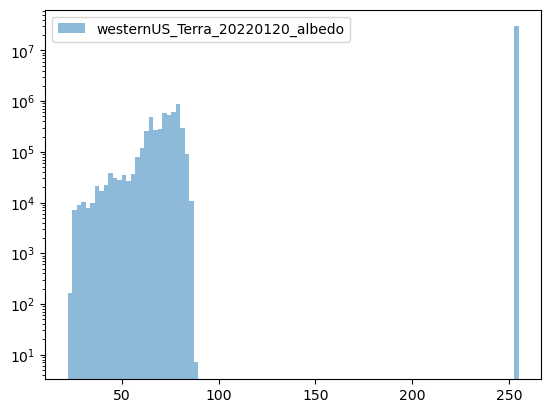

In [16]:
# through calendar WY 2023
# v2023.0e
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo*tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

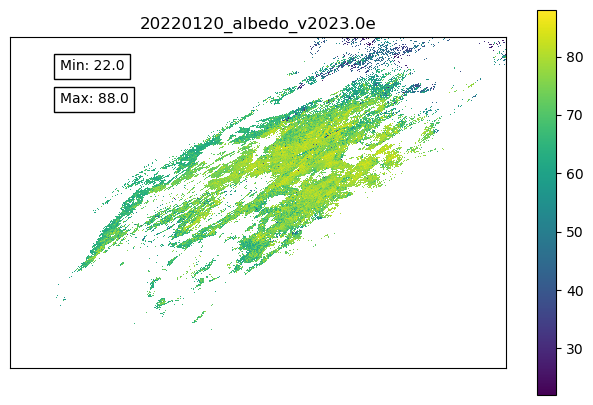

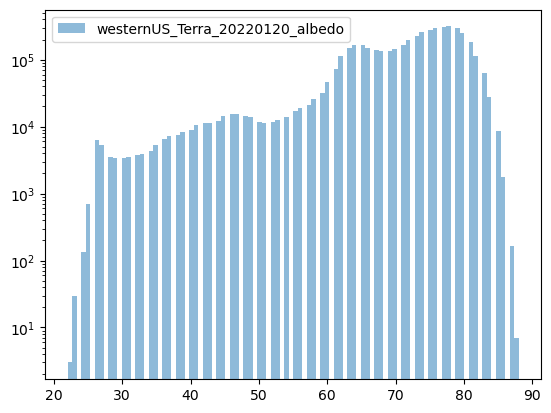

In [17]:
# through calendar WY 2023
# v2023.0e
stc_masked = np.ma.masked_equal(stc.band_data.data, 255)
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc_masked
ax.imshow(arr, interpolation='None')
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
# Add colorbar
cbar = plt.colorbar(ax.imshow(arr, interpolation='None'))

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

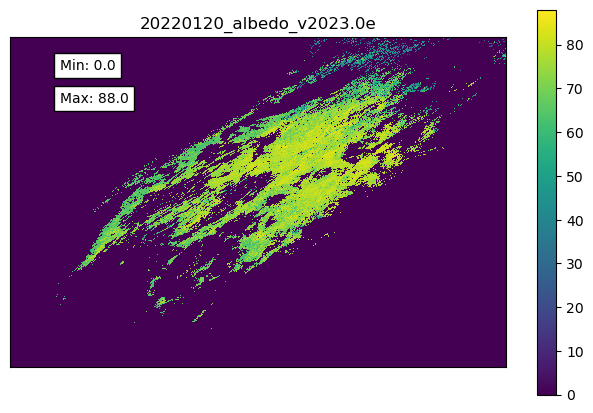

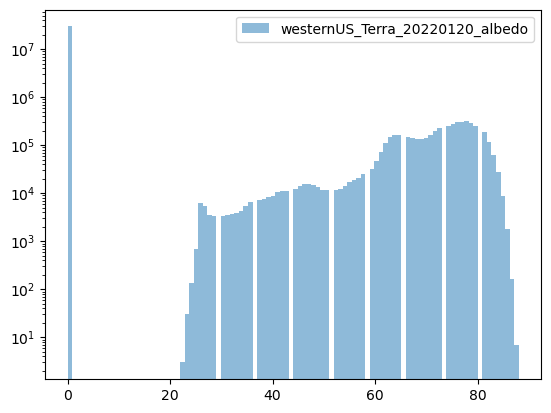

In [18]:
# through calendar WY 2023
# v2023.0e
import copy
stc_reset = copy.deepcopy(stc.band_data.data)
stc_reset[stc_reset==255] = 0

fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc_reset
ax.imshow(arr, interpolation='None')
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
# Add colorbar
cbar = plt.colorbar(ax.imshow(arr, interpolation='None'))

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

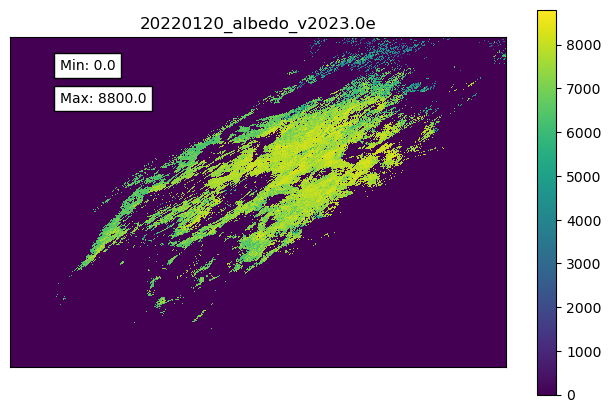

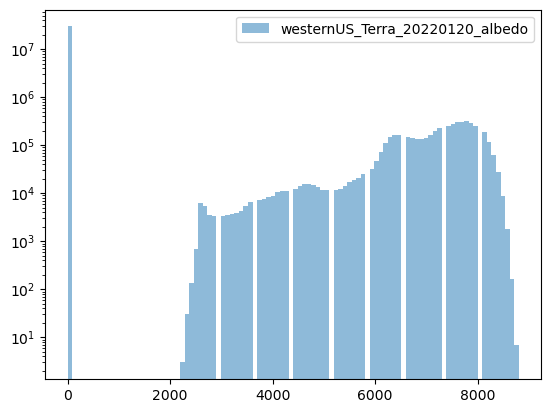

In [19]:
stc_reset_100 = stc_reset * 100
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc_reset_100
ax.imshow(arr, interpolation='None')
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
# Add colorbar
cbar = plt.colorbar(ax.imshow(arr, interpolation='None'))

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

In [20]:
diff = stc_reset_100 - stc_v03.band_data.data
diff.shape

(4800, 7200)

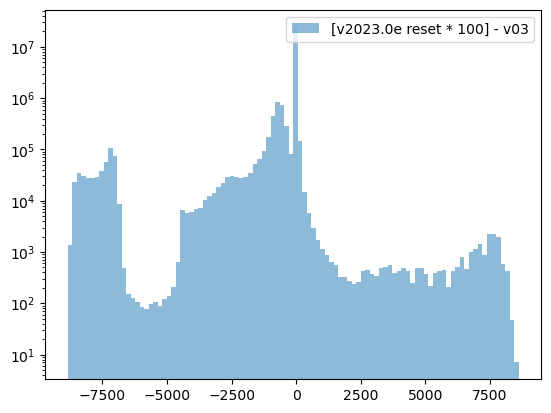

In [21]:
plt.figure()
plt.hist(diff.flatten(), bins=100, alpha=0.5, label='[v2023.0e reset * 100] - v03');
plt.yscale('log')
plt.legend();

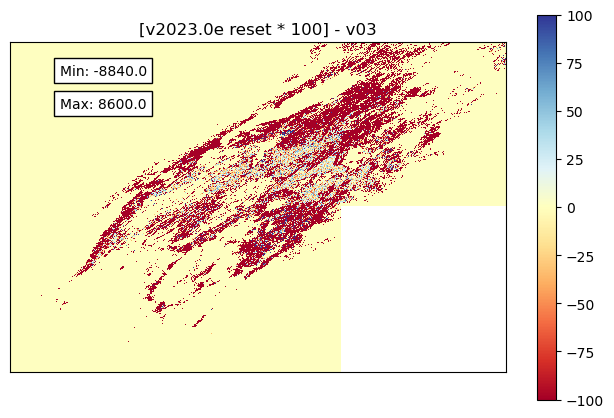

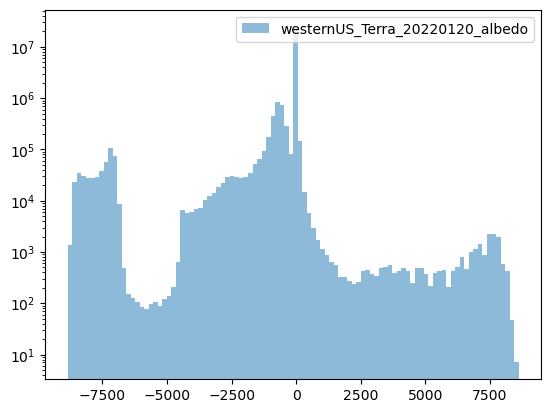

In [22]:
fig, ax = plt.subplots(1, figsize=(8,5))
arr = diff
interpolation='None'
cmap='RdYlBu'
vmin=-100
vmax=100
ax.imshow(arr, interpolation=interpolation, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title('[v2023.0e reset * 100] - v03');

# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
# add colorbar
cbar = plt.colorbar(ax.imshow(arr, interpolation=interpolation, cmap=cmap, vmin=vmin, vmax=vmax))
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

In [23]:
type(stc), type(stc.band_data), type(stc.band_data.data)

(xarray.core.dataset.Dataset, xarray.core.dataarray.DataArray, numpy.ndarray)

In [24]:
def reset_and_rescale(ds, ndv=255, scale=100, varname='band_data'):
    ''' Rescale v2023.0e MODSCAG albedo to v03 standards
    Range: 0-10000
    NDV: 0
    arr: xarray.core.dataset.Dataset
    '''
    # Create a deep copy of the array 
    ds_reset = copy.deepcopy(ds)

    # Extract numpy array
    arr = ds_reset[varname].data
    
    # Reset ndv to 0
    arr[arr==ndv] = 0

    # Rescale to 0-10000 and assign to the dataset
    ds_reset[varname].data = arr * scale

    return ds_reset

In [25]:
# through calendar WY 2023
# v2023.0e
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo*tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))


stc_from_func = reset_and_rescale(stc)

In [26]:
stc_from_func

<xarray.Dataset> Size: 138MB
Dimensions:      (x: 7200, y: 4800)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 58kB -1.112e+07 -1.112e+07 ... -7.784e+06
  * y            (y) float64 38kB 5.56e+06 5.559e+06 ... 3.337e+06 3.336e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 138MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

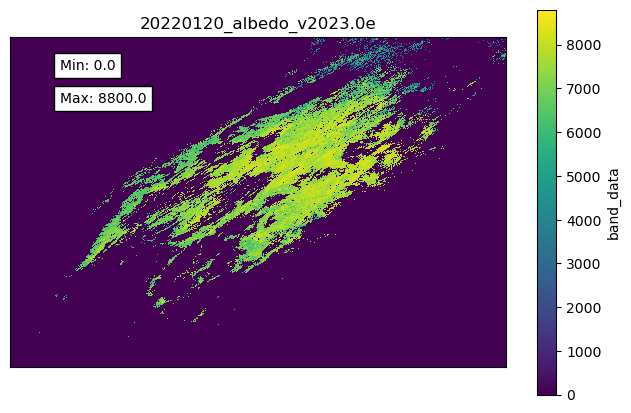

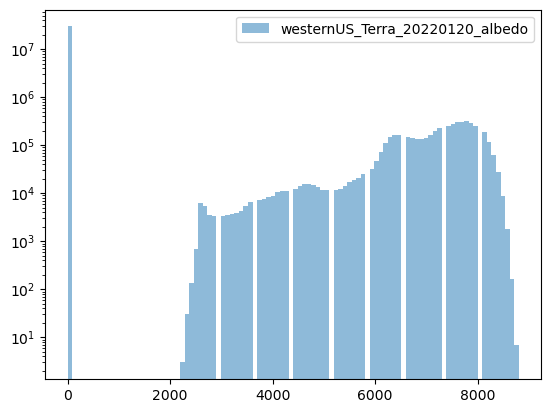

In [27]:
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc_from_func.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

In [28]:
import rioxarray as riox

In [29]:
stc_from_func.rio.to_raster('test.tif')

In [30]:
test = np.squeeze(xr.open_dataset('test.tif'))
test

<xarray.Dataset> Size: 138MB
Dimensions:      (x: 7200, y: 4800)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 58kB -1.112e+07 -1.112e+07 ... -7.784e+06
  * y            (y) float64 38kB 5.56e+06 5.559e+06 ... 3.337e+06 3.336e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 138MB ...

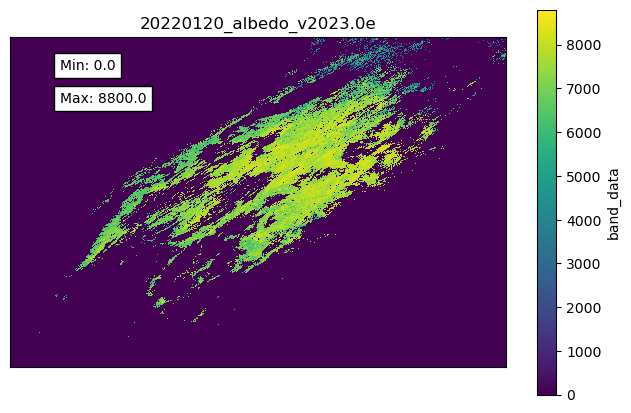

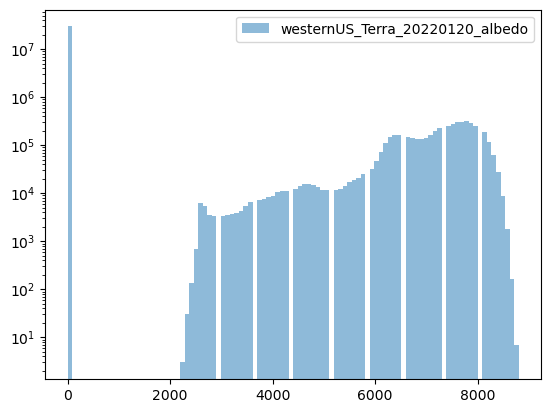

In [31]:
fig, ax = plt.subplots(1, figsize=(8,5))
arr = test.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

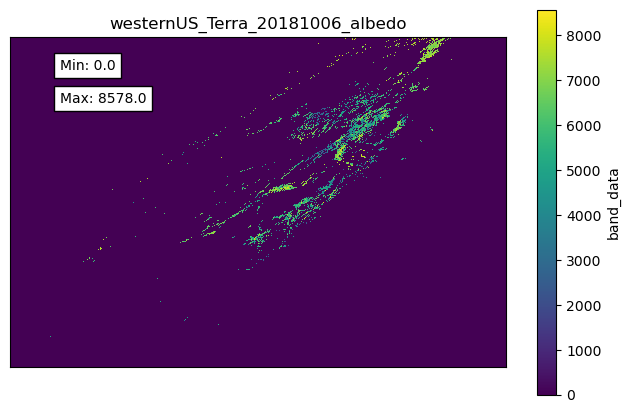

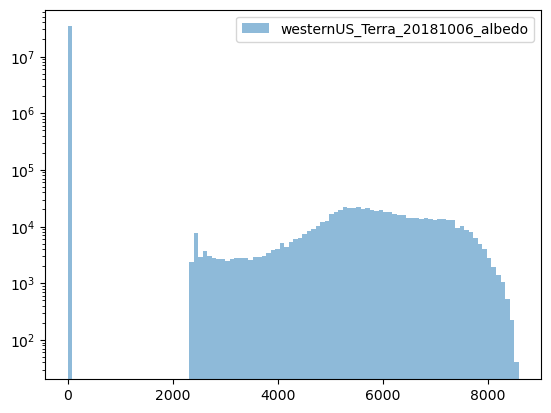

In [33]:
# Check a new one
# through calendar WY 2023
# v2023.0e
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2019'
stc_fn = h.fn_list(stc_dir, f'*albedo*tif')[5]
stc = np.squeeze(xr.open_dataset(stc_fn))

fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc.band_data
arr.plot.imshow()
plt.title(PurePath(stc_fn).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

In [ ]:
%%time
basin = 'blue_river'
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
basindirs = h.fn_list(workdir, f'{basin}*')
print(basindirs)

# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
days = h.fn_list(basindirs[0], f"*/*/{month}*/smrf_energy_balance*.nc")
# days = h.fn_list(basindirs[0], f"*/*/{month}*/net_solar.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/net_solar.nc")]
print(len(days[0]), len(days[1]))

# Read in datasets
isnobal_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
modis_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/blue_river_100m_isnobal', '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/blue_river_100m_isnobal_solar_albedo']
365 365
CPU times: user 11.7 s, sys: 3.92 s, total: 15.6 s
Wall time: 56.2 s


0 248
1 141
2 95
3 197
4 0
5 304
6 189
7 308
8 201
9 170


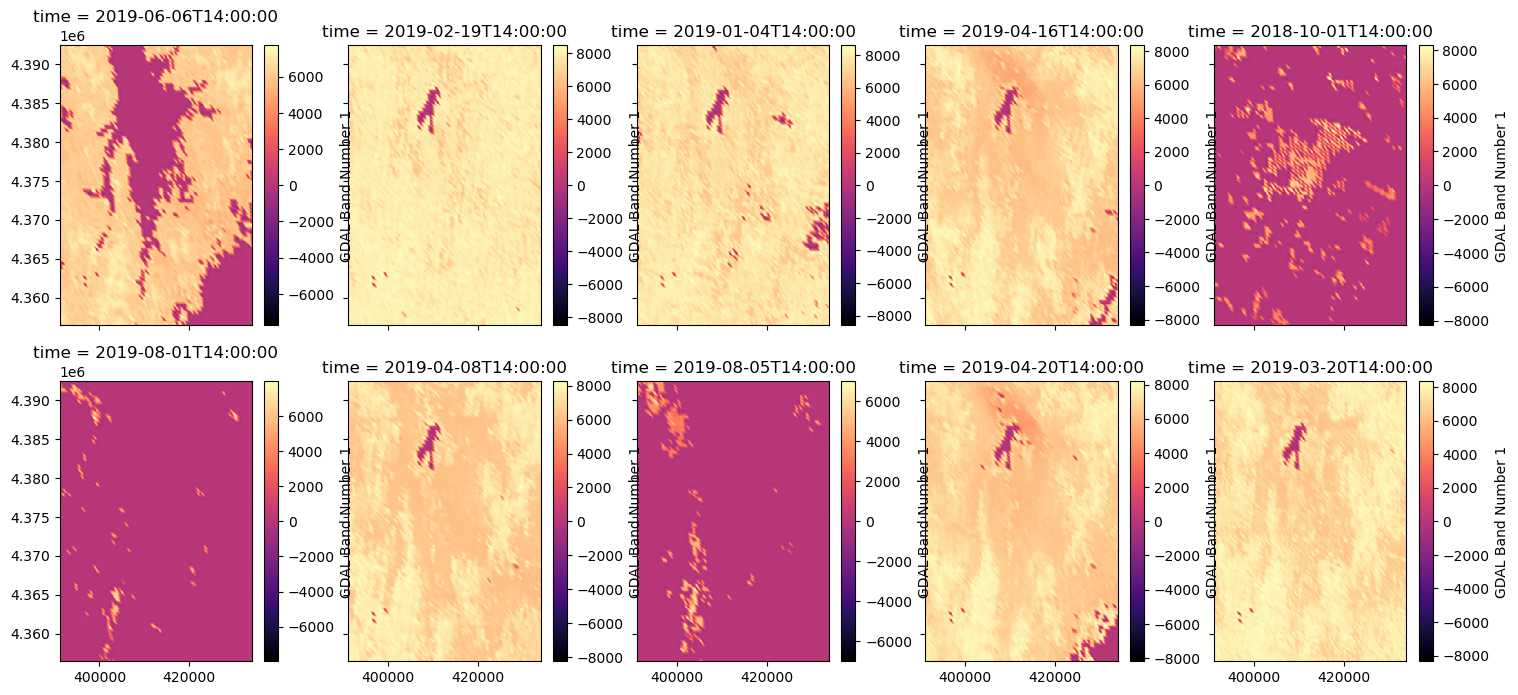

In [ ]:
fig, axa = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
for jdx, f in enumerate(np.random.choice(np.arange(0, 365), 10)):
    print(jdx, f)
    ax = axa.flatten()[jdx]
    modis_hrrr_list[f].isel(time=14).albedo.plot(ax=ax, cmap='magma')
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xticks([])